In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim 
from pandas import json_normalize
from bs4 import BeautifulSoup

# Note - The maps do not render on Github so please try running on https://nbviewer.jupyter.org/

# The Problem

With increasing tourism, people want to optimize their stay and make the most out of it. Thus, an ideal location is what people seek whist making plans for touring. Keeping the above in mind, companies strive to find an ideal location where their business can bloom and this project offers a preliminary insight into the current state of affairs.

# Import Torronto suburb data from Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
text = requests.get(url).text
soup = BeautifulSoup(text,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})

## Convert the data into lists and combining duplicate post codes (if any)

In [3]:
post_code = []
borough = []
neighbourhood = []
for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3: # Because there are 3 columns
        if (cells[0].find(text=True).strip("\n")) not in post_code:
            post_code.append(cells[0].find(text=True).strip("\n"))
            borough.append(cells[1].find(text=True).strip("\n"))
            neighbourhood.append(cells[2].find(text=True).strip("\n"))
        else:
            index = post_code.index((cells[0].find(text=True).strip("\n")))
            neighbourhood[index] = neighbourhood[index]+str(",")+cells[2].find(text=True).strip("\n")

## Put the data in a a Pandas Dataframe

In [4]:
df = pd.DataFrame()
df["Post_code"] = post_code
df["Borough"] = borough
df["Neighbourhood"] = neighbourhood
df.head()

,Post_code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Remove rows where borough is not assigned

In [5]:
index = df[((df.Borough == 'Not assigned'))].index
df = df.drop(index).reset_index(drop=True)
df.head()

,Post_code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df.shape

(103, 3)

## Obtain latitude and longitudes of the neighbourhoods using geopy

In [7]:
Coordinates = []
accuracy = 0
full_address = np.array(df['Post_code']+","+df['Borough'])
geolocator = Nominatim(user_agent="foursquare_agent")
for i in full_address:
    try:
        location = geolocator.geocode(i)
        latitude = location.latitude
        longitude = location.longitude
        Coordinates.append((location.latitude,location.longitude))
        accuracy += 1
    except:
        pass
print("Percentage of neighbourhoods identified bby geopy are:",str(round(accuracy/len(df['Post_code'])*100,2)),"%")

Percentage of neighbourhoods identified bby geopy are: 20.39 %


Due to the unreliability of the above package, A CSV file which containing the geospatial locations of the suburbs was used

In [8]:
coord = pd.read_csv("Geospatial_Coordinates.csv")
coord.columns = ["Post_code","Latitude","Longitude"]
coord.head()

,Post_code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
loc_df = pd.merge(df,coord,on="Post_code")
loc_df

,Post_code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


## Initial Visualization of suburb locations

In [10]:
torronto_map = folium.Map(location=[43.7032, -79.3832], zoom_start=12)

for lat,lng,name in zip(loc_df['Latitude'],loc_df['Longitude'],loc_df['Neighbourhood']):
    name = folium.Popup(name,parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        popup = name,
        radius = 2,
        color = 'green'
        ).add_to(torronto_map)
    
torronto_map

## Get information about hotels from Forsquare API

In [11]:
CLIENT_ID = '2QN4SQFKKTFEY0RKFIVMII4O12XYDVLFKAMPOTX0AR3YS1WQ' # your Foursquare ID
CLIENT_SECRET = 'QFGCGD5IB3TFS5I1233PW3LKOMS3UNAJRDMDBTO3D004EY3O' # your Foursquare Secret
VERSION = '20180604'

In [12]:
address = 'Downtown Toronto, ON, Canada'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude_downtown_toronto = location.latitude
longitude_downtown_toronto = location.longitude
search_query = '4bf58dd8d48988d1fa931735'
radius = 18000
limit = 500

In [13]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_downtown_toronto, longitude_downtown_toronto,search_query, VERSION, radius, limit)
url

'https://api.foursquare.com/v2/venues/search?client_id=2QN4SQFKKTFEY0RKFIVMII4O12XYDVLFKAMPOTX0AR3YS1WQ&client_secret=QFGCGD5IB3TFS5I1233PW3LKOMS3UNAJRDMDBTO3D004EY3O&ll=43.6563221,-79.3809161&categoryId=4bf58dd8d48988d1fa931735&v=20180604&radius=18000&limit=500'

In [14]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f08941a16b1975fb94c5921'},
 'response': {'venues': [{'id': '4ad4c05bf964a520a3f520e3',
    'name': 'Bond Place Hotel',
    'location': {'address': '65 Dundas St E',
     'crossStreet': 'at Bond St.',
     'lat': 43.65618805882607,
     'lng': -79.3784520985319,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.65618805882607,
       'lng': -79.3784520985319}],
     'distance': 199,
     'postalCode': 'M5B 2G8',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['65 Dundas St E (at Bond St.)',
      'Toronto ON M5B 2G8',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1fa931735',
      'name': 'Hotel',
      'pluralName': 'Hotels',
      'shortName': 'Hotel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1594397750',
    'hasPerk': False},
   {'id': '51d212c34

## Convert the json file from Foursquare to a Pandas Dataframe

In [15]:
venues = results['response']['venues']
target_frame = json_normalize(venues)
print(target_frame.columns)

Index(['id', 'name', 'categories', 'referralId', 'hasPerk', 'location.address',
       'location.crossStreet', 'location.lat', 'location.lng',
       'location.labeledLatLngs', 'location.distance', 'location.postalCode',
       'location.cc', 'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'venuePage.id'],
      dtype='object')


## Clean the data set

In [18]:
try:
    target_frame = target_frame.drop(['id','referralId','hasPerk','location.crossStreet','location.labeledLatLngs','location.cc','location.state','location.country','location.distance','location.address','venuePage.id','location.neighborhood'],axis=1)
except:
        target_frame = target_frame.drop(['id','referralId','hasPerk','location.crossStreet','location.labeledLatLngs','location.cc','location.state','location.country','location.distance','location.address','venuePage.id'],axis=1)

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

target_frame['categories'] = target_frame.apply(get_category_type, axis=1)
target_frame.columns = [column.split('.')[-1] for column in target_frame.columns]
target_frame.head()

,name,categories,lat,lng,postalCode,city,formattedAddress
0,Bond Place Hotel,Hotel,43.656188,-79.378452,M5B 2G8,Toronto,"[65 Dundas St E (at Bond St.), Toronto ON M5B ..."
1,Chelsea Hotel,Hotel,43.658498,-79.383097,M5G 1Z4,Toronto,"[33 Gerrard Street West (at Yonge St), Toronto..."
2,Edward Village,Hotel,43.770737,-79.336267,M2J 4R2,North York,"[185 Yorkland Blvd, North York ON M2J 4R2, Can..."
3,Embassy Suites by Hilton,Hotel,43.687789,-79.596418,M9W 5G1,Toronto,"[262 Carlingview Drive, Toronto ON M9W 5G1, Ca..."
4,Comfort Inn,Hotel,43.691386,-79.625047,L4V 1E4,Mississauga,"[6355 Airport Rd., Mississauga ON L4V 1E4, Can..."


In [20]:
target_frame.columns = ["Name","Category","Latitude","Longitude","Post_code","City","Address"]
target_frame.head()

,Name,Category,Latitude,Longitude,Post_code,City,Address
0,Bond Place Hotel,Hotel,43.656188,-79.378452,M5B 2G8,Toronto,"[65 Dundas St E (at Bond St.), Toronto ON M5B ..."
1,Chelsea Hotel,Hotel,43.658498,-79.383097,M5G 1Z4,Toronto,"[33 Gerrard Street West (at Yonge St), Toronto..."
2,Edward Village,Hotel,43.770737,-79.336267,M2J 4R2,North York,"[185 Yorkland Blvd, North York ON M2J 4R2, Can..."
3,Embassy Suites by Hilton,Hotel,43.687789,-79.596418,M9W 5G1,Toronto,"[262 Carlingview Drive, Toronto ON M9W 5G1, Ca..."
4,Comfort Inn,Hotel,43.691386,-79.625047,L4V 1E4,Mississauga,"[6355 Airport Rd., Mississauga ON L4V 1E4, Can..."


## Put all the hotels on the map

In [21]:
from folium import plugins

incidents = plugins.MarkerCluster().add_to(torronto_map)
for lat,lng,name in zip(pd.to_numeric(target_frame['Latitude']),pd.to_numeric(target_frame['Longitude']),target_frame['Name']):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(icon='Hotel'),
        popup=name).add_to(incidents)
    
torronto_map

## Repeat the same procedure for Tourist Attractions

### Monuments and landmarks

In [22]:
search_query = '4bf58dd8d48988d12d941735'
radius = 18000
limit = 500

In [23]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_downtown_toronto, longitude_downtown_toronto,search_query, VERSION, radius, limit)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f089377a0a468438ff8d262'},
 'response': {'venues': [{'id': '4ad4c05ef964a520a0f620e3',
    'name': "St. Michael's Cathedral",
    'location': {'address': '66 Bond St.',
     'crossStreet': 'at Shuter St',
     'lat': 43.65500673830438,
     'lng': -79.37706093077023,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.65500673830438,
       'lng': -79.37706093077023}],
     'distance': 343,
     'postalCode': 'M5B 1Z2',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['66 Bond St. (at Shuter St)',
      'Toronto ON M5B 1Z2',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d132941735',
      'name': 'Church',
      'pluralName': 'Churches',
      'shortName': 'Church',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_church_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1594397816',
    'hasPerk': False}

In [24]:
venues = results['response']['venues']
landmarks_frame = json_normalize(venues)
print(landmarks_frame.columns)

Index(['id', 'name', 'categories', 'referralId', 'hasPerk', 'location.address',
       'location.crossStreet', 'location.lat', 'location.lng',
       'location.labeledLatLngs', 'location.distance', 'location.postalCode',
       'location.cc', 'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'location.neighborhood', 'venuePage.id'],
      dtype='object')


In [25]:
landmarks_frame = landmarks_frame.drop(['id','referralId','hasPerk','location.crossStreet','location.labeledLatLngs','location.cc','location.state','location.country','location.distance','location.address','venuePage.id','location.neighborhood'],axis=1)

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

landmarks_frame['categories'] = landmarks_frame.apply(get_category_type, axis=1)
landmarks_frame.columns = [column.split('.')[-1] for column in landmarks_frame.columns]
landmarks_frame.head()

,name,categories,lat,lng,postalCode,city,formattedAddress
0,St. Michael's Cathedral,Church,43.655007,-79.377061,M5B 1Z2,Toronto,"[66 Bond St. (at Shuter St), Toronto ON M5B 1Z..."
1,Mackenzie House,Monument / Landmark,43.655777,-79.378200,M5B 1X2,Toronto,"[82 Bond St, Toronto ON M5B 1X2, Canada]"
2,Skylon Tower,Monument / Landmark,43.655992,-79.379726,NaN,Niagara Falls,"[5200 Robinson St, Niagara Falls ON, Canada]"
3,Cenotaph: Sunnybrook,Monument / Landmark,43.720920,-79.378981,M4N 3M5,Toronto,"[2075 Bayview Avenue (Sunnybrook Hospital), To..."
4,CN Tower,Monument / Landmark,43.642536,-79.387182,M5V 2T6,Toronto,"[301 Front St W (at John St), Toronto ON M5V 2..."


In [27]:
landmarks_frame.columns = ["Name","Category","Latitude","Longitude","Post_code","City","Address"]

In [29]:
incidents = folium.map.FeatureGroup() 

for lat, lng, name in zip(landmarks_frame['Latitude'],landmarks_frame['Longitude'],landmarks_frame['Name']):
    name = folium.Popup(name,parse_html=True)
    folium.Marker([lat, lng],popup=name,icon = folium.Icon(color='red',)).add_to(torronto_map) 
    
torronto_map.add_child(incidents)

From the map above, a few observations can me made. first and foremost, we see that there are hubs where landmarks <i>(red markers)</i> are concentrated which meas we can use a K-shell decomposition to furthur classify all the landmarks and obtain information such as peak hours and expected visitors everyday. However, that is a topic for another day. Secondly,the fact the hubs for the hotels <i>(blue markers)</i> and landmarks are concentrated around the same area indicates a strong correlation between the two the reason for which is obvious.

To see the correlation better, we can put everything on a scatter plot

In [53]:
import numpy as np
x = np.linspace(0,2*np.pi,50)

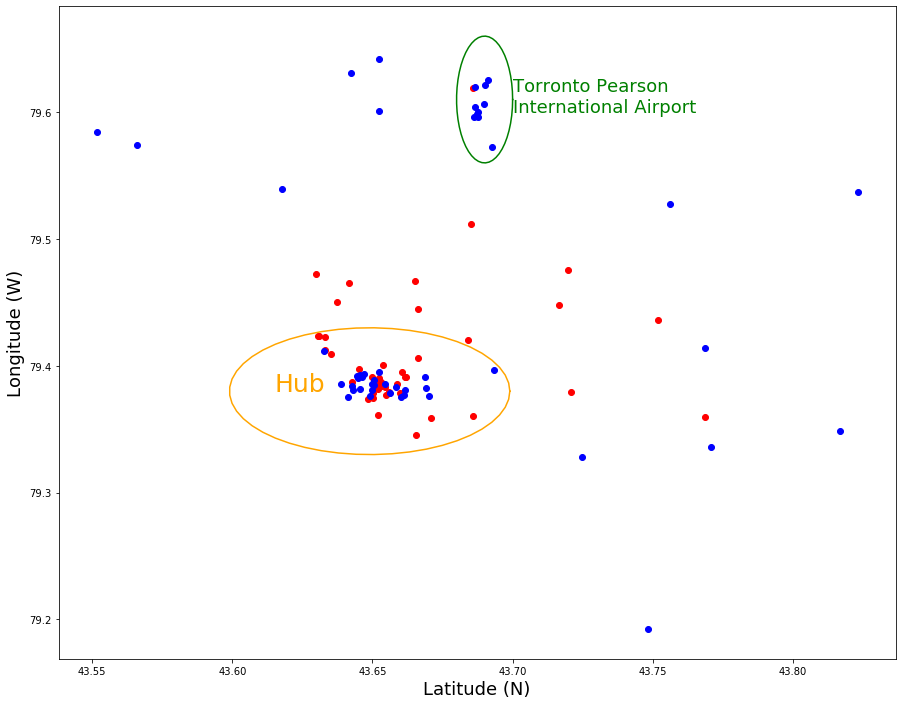

In [89]:
plt.figure(figsize=(15,12))
# Plot latitude and longitude
plt.plot(landmarks_frame['Latitude'],-landmarks_frame['Longitude'],'ro',target_frame['Latitude'],-target_frame['Longitude'],'bo')

# Draw circles
plt.plot(np.cos(x)*0.05+43.649,np.sin(x)*0.05+79.38,color='orange')
plt.plot(np.cos(x)*0.01+43.69,np.sin(x)*0.05+79.61,color='green')
# Annotate
plt.annotate("Hub",[43.615,79.38],color='orange',fontsize=25)
plt.annotate("Torronto Pearson \nInternational Airport",[43.7,79.6],color='green',fontsize=18)
plt.xlabel('Latitude (N)',fontsize=18)
plt.ylabel('Longitude (W)',fontsize=18);

# Conclusion

Landmarks in Torronto are concentrated in a hub as are most other systems such as traffic and the spread of deseases. Such models are ususaly treated using a K-shell decomposition. Furthermore, due to a high concentration of landmarks, there is also ahgh concentraction of hotels/inns in the same area due to obvious reasons. As one moves towards the outskirts, a decrese in the density of landmarks is observed and consequenty, the inns and hotels are sparsly distributed.

</br>
Another visible hotel hub was near the Torronto Pearson International airport. Ther was a high hotel density around the airport, the reason for which is also fairly obvious. However, there is virtually no hotel near the Downsview aiport which is rather surprising and unexpected.